In [1]:
%load_ext autoreload
%autoreload 2

In [55]:
import librosa
import librosa.display
import util as ut
import numpy as np
import os
import jams
import matplotlib.pyplot as plt

from scipy.stats import entropy
from tqdm import tqdm

In [25]:
rc = ut.RockCorpus()

In [27]:
rc.track_data(10).keys()

dict_keys(['raw_key', 'raw_root', 'calib_key', 'calib_root', 'hard_key', 'hard_root'])

In [28]:
from scipy.stats import entropy
from tqdm import tqdm

In [30]:
a = [0.2] * 5
b = [0] * 5
b[2] = 1

In [33]:
b_mat = np.array([b]*4)
a_mat = np.array([a]*4)

In [37]:
b_mat.shape

(4, 5)

In [35]:
entropy(b_mat, a_mat, axis=1)

array([1.60943791, 1.60943791, 1.60943791, 1.60943791])

In [32]:
entropy(a, b)

inf

## BUILD Jams that has key:rel_root annotation!



In [62]:
def text_to_relroot(path, track_dur):
    with open(path, 'r') as f:
        lines = f.readlines()

    ann = jams.Annotation(namespace='pitch_class', duration=track_dur)

    for i in range(len(lines) - 1):
        start_t, _, roman, rel_root, scale_degree, key, abs_root = lines[i].strip('\n').split('\t')
        end_t = lines[i+1].split('\t')[0]
        
        start_t = float(start_t) if float(start_t) >= 0 else 0
        event_dur = float(end_t) - float(start_t)
        tonic = librosa.midi_to_note(int(key), octave=False, unicode=False)

        ann.append(time=float(start_t), duration=event_dur, 
                   value={'tonic': tonic, 'pitch': int(rel_root)})
    
    return ann


In [63]:
for track_id in tqdm(range(len(rc))):

    track_dur = librosa.get_duration(filename=rc.audio_path(track_id))
    jam = jams.JAMS()
    jam.file_metadata.duration = track_dur

    dt_ann = text_to_relroot(rc.dt_anno_path(track_id), track_dur)
    dt_ann.annotation_metadata= jams.AnnotationMetadata(version='DT')
    jam.annotations.append(dt_ann)

    tdc_ann = text_to_relroot(rc.tdc_anno_path(track_id), track_dur)
    tdc_ann.annotation_metadata = jams.AnnotationMetadata(version='TdC',)
    jam.annotations.append(tdc_ann)

    jam.save(rc.jams_path(track_id))

100%|██████████| 200/200 [00:31<00:00,  6.43it/s]


In [64]:
jams.load(rc.jams_path(track_id))

<JAMS(file_metadata=<FileMetadata(...)>,
      annotations=[2 annotations],
      sandbox=<Sandbox(...)>)>

## GO FROM JAMS TO DATA MATS: KEY AND RELROOT

## LOWER PRIO: Key Jams

In [65]:
jam = jams.load(rc.jams_path(50))

In [66]:
anns = jam.search(namespace='pitch_class')

In [83]:
ann = anns[0]
frame_period = 4096 / 44100
num_frames = np.floor(ann.duration / frame_period)
f_times = np.arange(num_frames) * frame_period
out = ann.to_samples(f_times)

In [84]:
ann.duration / frame_period

1510.55419921875

In [85]:
def ann_mat(self, idx)

(1509, 13)

In [125]:
rc = ut.RockCorpus()

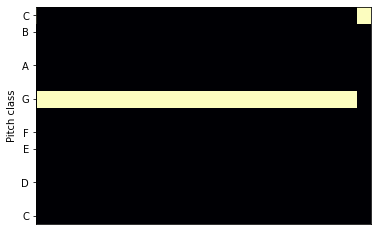

In [134]:
librosa.display.specshow(rc.ann_data(50)['key'].T, y_axis='chroma')

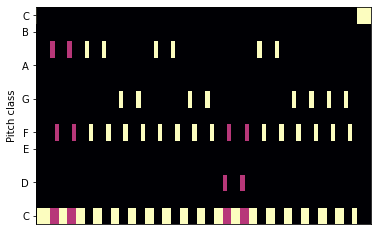

In [135]:
librosa.display.specshow(rc.ann_data(50)['root'].T, y_axis='chroma')

In [136]:
test_jam = jams.load(rc.jams_path(50))

In [171]:
data = rc.track_data(50)
ann_relroot = rc.ann_data(50)['root']
model_relroot = ut.relative_root(data['calib_key'], data['calib_root'])

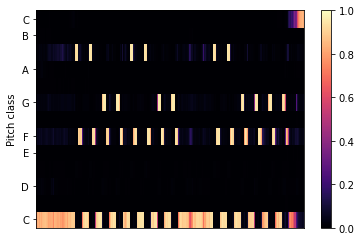

In [175]:
librosa.display.specshow(model_relroot.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [173]:
raw_rel_root = ut.relative_root(data['raw_key'], data['raw_root'])

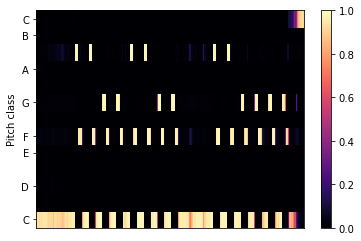

In [174]:
librosa.display.specshow(raw_rel_root.T, y_axis='chroma', vmin=0, vmax=1)
plt.colorbar()
plt.show()

In [176]:
np.mean(track_kl(ann_relroot, model_relroot))

0.27074549222409455

In [177]:
np.mean(track_kl(ann_relroot, raw_rel_root))

0.25212388579183614

In [142]:
def track_kl(label_mat, pred_mat):
    frames = min(len(label_mat), len(pred_mat))
    return entropy(label_mat[:frames], pred_mat[:frames], axis=1)

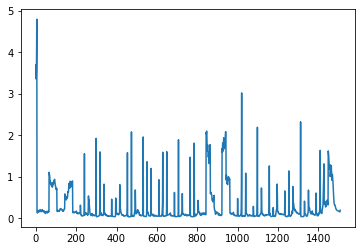

In [146]:
plt.plot(track_kl(ann_relroot, model_relroot))

In [147]:
kl_list = []
for i in range(len(rc)):
    data = rc.track_data(i)
    ann_relroot = rc.ann_data(i)['root']
    model_relroot = ut.relative_root(data['calib_key'], data['calib_root'])
    kl_list.append(track_kl(ann_relroot, model_relroot))

In [150]:
kl_means = [np.mean(arr) for arr in kl_list]

(array([46., 50., 35., 16., 17., 11.,  7.,  7.,  5.,  3.,  0.,  0.,  2.,
         0.,  1.]),
 array([0.11166083, 0.32708128, 0.54250172, 0.75792217, 0.97334261,
        1.18876306, 1.4041835 , 1.61960395, 1.83502439, 2.05044484,
        2.26586528, 2.48128573, 2.69670617, 2.91212662, 3.12754706,
        3.34296751]),
 <BarContainer object of 15 artists>)

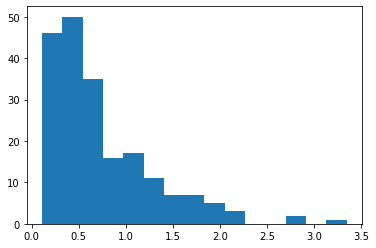

In [162]:
plt.hist(kl_means, bins='auto')

In [161]:
count.shape

(15,)

In [163]:
raw_kl_list = []
for i in range(len(rc)):
    data = rc.track_data(i)
    ann_relroot = rc.ann_data(i)['root']
    model_relroot = ut.relative_root(data['raw_key'], data['raw_root'])
    raw_kl_list.append(track_kl(ann_relroot, model_relroot))

(array([54., 41., 36., 20., 12., 11.,  7.,  4.,  5.,  3.,  1.,  3.,  0.,
         1.,  1.,  0.,  1.]),
 array([0.08716814, 0.29912369, 0.51107924, 0.72303479, 0.93499034,
        1.1469459 , 1.35890145, 1.570857  , 1.78281255, 1.9947681 ,
        2.20672366, 2.41867921, 2.63063476, 2.84259031, 3.05454586,
        3.26650142, 3.47845697, 3.69041252]),
 <BarContainer object of 17 artists>)

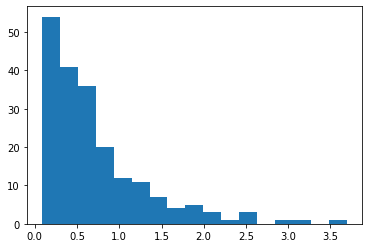

In [164]:
raw_kl_means = [np.mean(arr) for arr in raw_kl_list]
plt.hist(raw_kl_means, bins='auto')

In [166]:
np.mean(raw_kl_means)

0.7282303283067246

In [167]:
np.mean(kl_means)

0.7378298325117325

In [193]:
above_raw = []
above_cal = []
below_raw = []
below_cal = []

for pair in zip(raw_kl_means, kl_means):
    if pair[1] >= pair[0]:
        above_raw.append(pair[0])
        above_cal.append(pair[1])
    else:
        below_raw.append(pair[0])
        below_cal.append(pair[1])

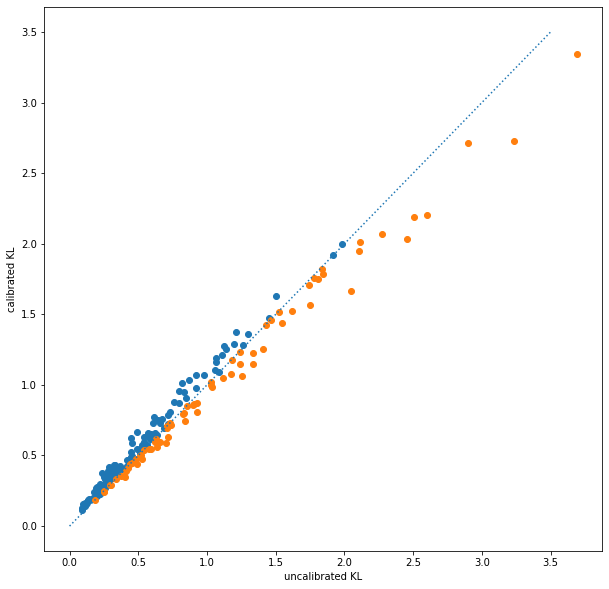

In [195]:
plt.figure(figsize=(10,10))
plt.scatter(above_raw, above_cal)
plt.scatter(below_raw, below_cal)
plt.ylabel('calibrated KL')
plt.xlabel('uncalibrated KL')
plt.plot([0,2,3.5], [0,2,3.5], ':')
plt.show()

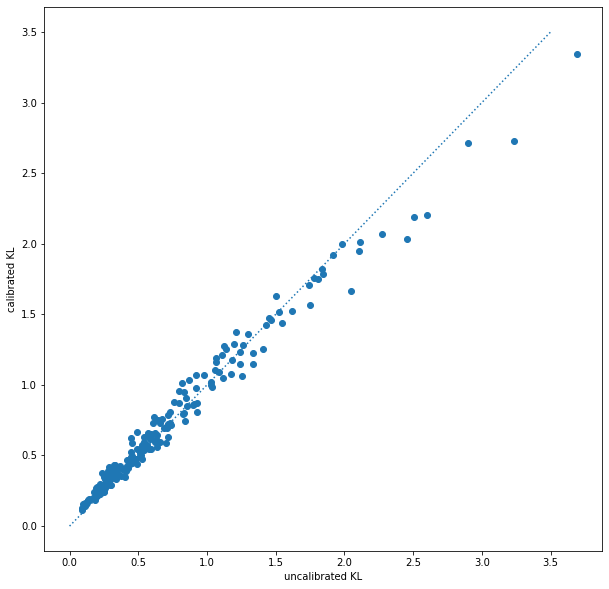

In [194]:
plt.figure(figsize=(10,10))
plt.scatter(raw_kl_means, kl_means)
plt.ylabel('calibrated KL')
plt.xlabel('uncalibrated KL')
plt.plot([0,2,3.5], [0,2,3.5], ':')
plt.show()